In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

[utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.


_ColormakerRegistry()

In [2]:

np.linspace

'neutromeratio'

[utils.py:54 - get_tautomer_transformation()] Index of atom that moves: 11.
[utils.py:60 - get_tautomer_transformation()] Index of atom that donates hydrogen: 2
[utils.py:78 - get_tautomer_transformation()] Index of atom that accepts hydrogen: 5


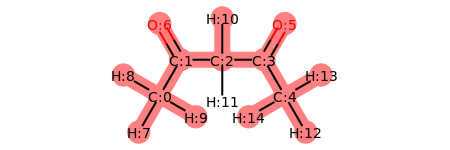

In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

tautomer_transformation = neutromeratio.get_tautomer_transformation(from_mol, to_mol)
neutromeratio.generate_hybrid_structure(ani_input, tautomer_transformation, neutromeratio.ani.ANI1_force_and_energy)

In [3]:
# define the alchemical atoms
alchemical_atoms=[tautomer_transformation['acceptor_hydrogen_idx'], tautomer_transformation['donor_hydrogen_idx']]

In [4]:
tautomer_transformation

{'donor_idx': 2,
 'hydrogen_idx': 11,
 'acceptor_idx': 5,
 'donor_hydrogen_idx': 11,
 'acceptor_hydrogen_idx': 15}

In [ ]:
np.random.seed(0)

# extract hydrogen donor idx and hydrogen idx for from_mol
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalSingleTopologyANI(device=device, alchemical_atoms=alchemical_atoms, ani_input=ani_input)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
ani_trajs = []
n_steps = 5000
energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['hybrid_atoms'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation)

energy_function.restrain_acceptor = True
energy_function.restrain_donor = True

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['hybrid_atoms'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)

x0 = np.array(ani_input['hybrid_coords']) * unit.angstrom
energie_list = []

for lamb in np.linspace(0, 1, 10):
    energy_function.lambda_value = lamb
    energy_function.minimize(ani_input)
    equilibrium_samples, energies = langevin.run_dynamics(x0, n_steps, stepsize=1.0 * unit.femtosecond, progress_bar=True)   
    energie_list.append(energies)
    equilibrium_samples = [x / unit.nanometer for x in equilibrium_samples]
    ani_traj = md.Trajectory(equilibrium_samples, ani_input['hybrid_topolog'])

    ani_trajs.append(ani_traj)

Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 22:30:53    -9414.745483        5.6626
BFGS:    1 22:30:53    -9415.111118        1.7253
BFGS:    2 22:30:53    -9415.255353        1.2870
BFGS:    3 22:30:53    -9415.308035        1.0827
BFGS:    4 22:30:53    -9415.352809        0.7167
BFGS:    5 22:30:53    -9415.397155        0.4234
BFGS:    6 22:30:53    -9415.411766        0.3069
BFGS:    7 22:30:53    -9415.422348        0.2596
BFGS:    8 22:30:53    -9415.430767        0.2513
BFGS:    9 22:30:53    -9415.439292        0.2199
BFGS:   10 22:30:53    -9415.445408        0.1867
BFGS:   11 22:30:53    -9415.451079        0.1594
BFGS:   12 22:30:53    -9415.456129        0.1598
BFGS:   13 22:30:53    -9415.459624        0.1618
BFGS:   14 22:30:53    -9415.462334        0.1510
BFGS:   15 22:30:53    -9415.465228        0.1401
BFGS:   16 22:30:54    -9415.468335        0.1659
BFGS:   17 22:30:54    -9415.471403        0.1425
BFGS:   18 22:30:54    -9415.47

100%|██████████| 5000/5000 [04:33<00:00, 18.30it/s, |force|=6.23e+3]


Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 22:35:39    -9415.593717        0.0004


100%|██████████| 5000/5000 [05:08<00:00, 16.23it/s, |force|=7.75e+3]


Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 22:40:49    -9415.593717        0.0004


100%|██████████| 5000/5000 [04:38<00:00, 17.95it/s, |force|=5.91e+3]


Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 22:45:29    -9415.593717        0.0004


100%|██████████| 5000/5000 [04:16<00:00, 19.52it/s, |force|=6580.28]


Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 22:49:47    -9415.593717        0.0004


100%|██████████| 5000/5000 [04:06<00:00, 20.26it/s, |force|=5.54e+3]


Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 22:53:55    -9415.593717        0.0004


100%|██████████| 5000/5000 [06:37<00:00, 12.57it/s, |force|=7.87e+3]


Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 23:00:36    -9415.593717        0.0004


  2%|▏         | 86/5000 [00:08<07:20, 11.15it/s, |force|=5.6e+3] 

In [ ]:
neutromeratio.utils.generate_nglview_object(ani_trajs[0], tautomer_transformation)

In [ ]:
import matplotlib.pyplot as plt

for energy in energie_list:
    e = [x / unit.kilocalorie_per_mole for x in energy]
    plt.plot(e, label='lambda: {}'.format(str(lamb)))

In [6]:
a = 10.01340

In [7]:
f"{a}"

'10.0134'

In [10]:
f"{a:0.4f}"

'10.0134'